We consider Gaussian Mixture target 
\begin{equation}
    q_0 = \sum_{k=1}^K w_k \mathcal{N}(x; m_k, C_k)
\end{equation}
The forward process with  $\lambda_t = e^{-t}$ and $\sigma_t = \sqrt{1 - e^{-2t}}$ gives
\begin{align*}
	q_t(y) = &  \int_{R^d} \frac{1}{(\sqrt{2\pi} \sigma_t)^d} \cdot \exp \left( -\frac{\|y - \lambda_t x\|_2^2}{2\sigma_t^2} \right) q_0(x) \mathrm{d} x \\
	= & \sum_{k=1}^K w_k \mathcal{N}(y; \lambda_t m_k, \lambda_t^2 C_k + \sigma_t^2 I)
\end{align*}

The score function is 
\begin{align*}
	\nabla_x \log q_t(x)
	= & -\sum_{k=1}^K\frac{w_k\mathcal{N}(x; \lambda_t m_k, \lambda_t^2 C_k + \sigma_t^2 I)}{q_t(x)} (\lambda_t^2C_k + \sigma_t^2I)^{-1}(x - \lambda_t m_k)
\end{align*}


In [33]:
using PyPlot
using LinearAlgebra
using Random 
using Distributions
using KernelDensity 
using NPZ

function Gaussian_density(x_mean::Array{FT,1}, xx_cov::Array{FT,2}, x::Array{FT,1}; propto::Bool= true, xx_prec = nothing, det_xx_cov = nothing) where {FT<:AbstractFloat}
    N_x = size(x_mean,1)
    if det_xx_cov === nothing
        det_xx_cov = det(xx_cov)
    end
    Cinv_x =  (xx_prec === nothing ? xx_cov\(x - x_mean) : xx_prec*(x - x_mean))
        
    Z = (propto ? sqrt(det_xx_cov) : (2π)^(N_x/2)*sqrt(det_xx_cov))
    return exp( -1/2*((x - x_mean)'* Cinv_x)) / Z

end
function Gaussian_mixture_density(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov::Array{FT,3}, x::Array{FT,1}; propto::Bool= true, xx_prec = nothing, det_xx_cov = nothing) where {FT<:AbstractFloat}
    ρ = 0.0
    N_modes, dim = size(x_mean)
    
    for i = 1:N_modes
        ρ += x_w[i]*Gaussian_density(x_mean[i,:], xx_cov[i,:,:], x; propto = propto, 
        xx_prec = (xx_prec === nothing ? nothing : xx_prec[i,:,:]),
        det_xx_cov = (det_xx_cov === nothing ? nothing : det_xx_cov[i]))
    end
    
    return ρ
end

function Gaussian_mixture_score_function(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov::Array{FT,3}, x::Array{FT,1}; xx_prec = nothing, det_xx_cov = nothing) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    ρ = Gaussian_mixture_density(x_w, x_mean, xx_cov, x; propto= true, xx_prec = xx_prec, det_xx_cov = det_xx_cov)
    ∇logρ = zeros(FT, dim)
    for i = 1:N_modes
        Cinv_x =  (xx_prec === nothing ? xx_cov[i,:,:]\(x_mean[i,:] - x) : xx_prec[i,:,:]*(x_mean[i,:] - x))
        
        ∇logρ += x_w[i]*Gaussian_density(x_mean[i,:], xx_cov[i,:,:], x; propto = true, 
        xx_prec = (xx_prec === nothing ? nothing : xx_prec[i,:,:]),
        det_xx_cov = (det_xx_cov === nothing ? nothing : det_xx_cov[i])) * Cinv_x
    end
    ∇logρ /= ρ
    return ∇logρ
end

Gaussian_mixture_score_function (generic function with 1 method)

In [2]:
function compute_mt_covt(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov::Array{FT,3}, t::FT) where {FT<:AbstractFloat}
    N_modes, N_x = size(x_mean)
    x_mean_t = copy(x_mean)
    xx_cov_t = copy(xx_cov)  
    λ_t , σ_t = exp(-t), sqrt(1 - exp(-2t))
    for i = 1:N_modes
        x_mean_t[i,:] = λ_t*x_mean[i,:]
        xx_cov_t[i,:,:] = λ_t^2*xx_cov[i,:,:] + σ_t^2*I
    end
    return x_mean_t, xx_cov_t
end

function compute_qt(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov::Array{FT,3}, t::FT, x::Array{FT,1}) where {FT<:AbstractFloat}
    N_modes, _ = size(x_mean)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t)
    qt = Gaussian_mixture_density(x_w, x_mean_t, xx_cov_t, x; propto= false)
    return qt
end


function compute_qt(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov::Array{FT,3}, t::FT, xx::Array{FT,2}) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t)
    
    det_xx_cov_t = zeros(N_modes)
    xx_prec_t = zeros(N_modes, dim, dim)
    for im = 1:N_modes
        det_xx_cov_t[im] = det(xx_cov_t[im,:,:])
        xx_prec_t[im,:,:] = inv(xx_cov_t[im,:,:])
    end
    
    qt = zeros(N_x)
    for i = 1:N_x
        qt[i] = Gaussian_mixture_density(x_w, x_mean_t, xx_cov_t, xx[i,:]; propto= false, det_xx_cov=det_xx_cov_t, xx_prec = xx_prec_t)
    end
    return qt
end


function compute_qt_score(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov::Array{FT,3}, t::FT, x::Array{FT,1}) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t)
    ∇logqt = Gaussian_mixture_score_function(x_w, x_mean_t, xx_cov_t, x) 
    return ∇logqt
end



function compute_qt_score(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov::Array{FT,3}, t::FT, xx::Array{FT,2}) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t)
    
    det_xx_cov_t = zeros(N_modes)
    xx_prec_t = zeros(N_modes, dim, dim)
    for im = 1:N_modes
        det_xx_cov_t[im] = det(xx_cov_t[im,:,:])
        xx_prec_t[im,:,:] = inv(xx_cov_t[im,:,:])
    end
    
    
    ∇logqt = zeros(N_x, dim)
    for i = 1:N_x
        ∇logqt[i, :] = Gaussian_mixture_score_function(x_w, x_mean_t, xx_cov_t, xx[i,:], det_xx_cov=det_xx_cov_t, xx_prec = xx_prec_t) 
    end
    return ∇logqt
end



compute_qt_score (generic function with 2 methods)

In [15]:
function compute_U_GM(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov::Array{FT,3}, t::FT, T::FT, xx::Array{FT,2}) where {FT<:AbstractFloat}
    # warning this v differs the paper by a sign
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    ∇logqt = compute_qt_score(x_w, x_mean, xx_cov, T-t, xx)
    return xx + ∇logqt
end


compute_U(t, xx) = compute_U_GM(x_w, x_mean, xx_cov, t, T, (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx) )

function score_error(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov::Array{FT,3}, δ::FT, t::FT, T::FT, xx::Array{FT,2}; error_type::String) where {FT<:AbstractFloat}

    N_x, dim = size(xx)
    if error_type == "constant"
        return δ*ones(N_x, dim)
    
    elseif error_type == "linear" 
        m = x_w' * x_mean
        return δ/sqrt(dim)*(xx - ones(N_x)*m)
    
    elseif error_type == "sinusoidal" 
        #return δ*sin.(2pi*xx)
        m = x_w' * x_mean
        return δ/sqrt(dim)*sin.(xx) .* (xx - ones(N_x)*m)
        
    else
        @error("error_type == ", error_type, " has not been implemented")
    end

end

score_error (generic function with 1 method)

# 1D PDE solver

In [16]:
# rho_t = q_{T-t}
# drho/dt = -d(v rho)/dx 
# v = x +  s(T-t, x)           


function limiter(qq)
    eps = 1.e-15
    q_ll, q_l, q_r, q_rr = qq[1], qq[2], qq[3], qq[4]

    ind_l = (q_r - q_l) / (q_l - q_ll + eps)
    ind_r = (q_r - q_l) / (q_rr - q_r + eps)

    phi_l = (ind_l>0.0 ? 2*ind_l/(ind_l+1) : 0.0)
    phi_r = (ind_r>0.0 ? 2*ind_r/(ind_r+1) : 0.0)

    q_minus = q_l + 0.5 * phi_l * (q_l - q_ll)
    q_plus  = q_r - 0.5 * phi_r * (q_rr - q_r)

    return q_minus, q_plus         
end
         

function reconstruct(q)         
    Ne = length(q)  # n+4
    
    # add ghost point values
    q_ext = [q[1]; q[1]; q...; q[end]; q[end]]
            
    q_minus, q_plus = zeros(Ne+1), zeros(Ne+1)

    for i = 1:Ne+1
        q_minus[i], q_plus[i] = limiter(q_ext[i: i + 3])
    end
            
    return q_minus, q_plus
end          

        
function residual(q_l, q_r, v)
    Ne = length(v) - 1
    f = zeros(Ne+1)
    for i = 1:Ne+1
        # warning this v is -v for hyperbolic equation
        f[i] = (v[i] >= 0 ? v[i]*q_l[i] : v[i]*q_r[i])
    end
    f[1] = f[Ne+1] = (f[1] + f[Ne+1])/2
    return f[1:Ne] - f[2:Ne+1]          
end
            
            
function time_update(xx, xc, q, t, dt, compute_v::Function)
    # dq/dt = d(vq)/dx
    dx = xx[2] - xx[1]
    Ne = length(q)
                
    v = compute_v(t, xx)
    q_l, q_r = reconstruct(q)            
    r = residual(q_l, q_r, v)
    q_h = q + dt/dx*r
                
    v_h = compute_v(t + dt, xx)         
    q_h_l, q_h_r = reconstruct(q_h)            
    r_h = residual(q_h_l, q_h_r, v_h)
                
    q_n = q + 0.5*dt/dx*(r + r_h)
                
    return q_n
end
                
function solve(x_l, x_r, Ne, T, Nt, q0, compute_v::Function)
    dx = (x_r - x_l) / Ne
    dt = T/Nt
    xx = LinRange(x_l, x_r, Ne + 1)
    xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
                
    qs = zeros(Nt+1, Ne)
    qs[1, :] .= q0
    for i = 1:Nt
        t = dt * (i-1)
        qs[i+1, :] = time_update(xx, xc, qs[i, :], t, dt, compute_v)            
    end
            
    return qs
end
            
            


solve (generic function with 2 methods)

## Setup

In [17]:
x_w = [0.3; 0.3; 0.4]
x_mean = vcat([-6.0;;], [4.0;;], [6.0;;])
xx_cov = vcat([0.25;;;], [0.25;;;], [0.25;;;])

x_l, x_r, Ne = -10, 10, 1000
Δx = (x_r - x_l) / Ne
xx = LinRange(x_l, x_r, Ne + 1)
xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
T, Nt = 4.0, 4000

#ρ0 = compute_qt(x_w, x_mean, xx_cov, T, Array(reshape(xc, (Ne, 1))))
#ρ0 = compute_qt([1.0;], [0.0;;], [1.0;;;], 0.0, Array(reshape(xc, (Ne, 1))))


(4.0, 4000)

## Compute

In [18]:
error_types = ["constant"; "linear"; "sinusoidal"]
δs = [0.01; 0.02; 0.04; 0.08; 0.16]  
Ntype = length(error_types) 
Nδ = length(δs)

# Gaussian initial condition
# ρ0 = compute_qt(x_w, x_mean, xx_cov, T, Array(reshape(xc, (Ne, 1))))
ρ0 = compute_qt([1.0;], [0.0;;], [1.0;;;], 0.0, Array(reshape(xc, (Ne, 1))))

ρs = zeros(Ntype, Nδ, Nt+1, Ne) 
for itype = 1:Ntype
    for iδ = 1:Nδ 
        compute_V(t, xx) = compute_U(t, xx) + score_error(x_w, x_mean, xx_cov, δs[iδ], t, T, (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx) ;error_type = error_types[itype])
        ρs[itype, iδ, :, :] = solve(x_l, x_r, Ne, T, Nt, ρ0, compute_V)
    end
end

In [19]:
q0 = compute_qt(x_w, x_mean, xx_cov, 0.0, Array(reshape(xc, (Ne, 1))))
TVes = zeros(Ntype, Nδ) 
rmeanes = zeros(Ntype, Nδ)   #relative mean error
rcoves = zeros(Ntype, Nδ)    #relative covariance error
GM_mean = x_w' * x_mean[:,1]
GM_cov = x_w' * xx_cov[:,1,1] + x_w'* (x_mean[:,1] .- GM_mean).^2
for itype = 1:Ntype
    for iδ = 1:Nδ 
        ρT = ρs[itype, iδ, end, :]
        TVes[itype, iδ] = sum(abs.(ρT - q0)) / 2.0 * (xc[2] - xc[1])
        GM_mean_esti = ρT' * xc * (xc[2] - xc[1])
        rmeanes[itype, iδ] = abs(GM_mean_esti - GM_mean) / GM_mean
        rcoves[itype, iδ]  = abs(ρT'*(xc .- GM_mean_esti).^2* (xc[2] - xc[1]) - GM_cov) / GM_cov
    end
end

## Visualize

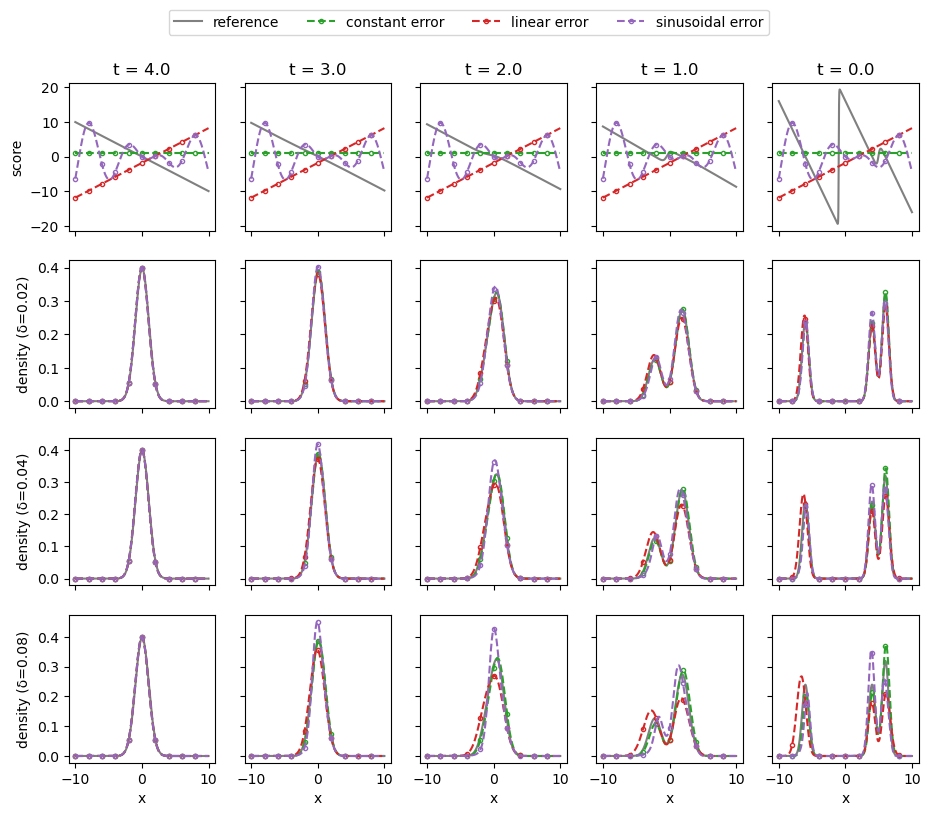

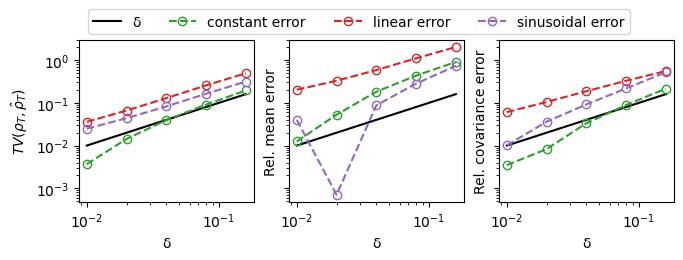

In [20]:
nrows, ncols = 4, 5
fig, ax = fig, ax = PyPlot.subplots(nrows = nrows, ncols=ncols, sharex=true, sharey="row", figsize=(10,8))

    
## plot score at different time
for i  = 1:ncols
    t = T - T*(i-1)/(ncols - 1)
    δ = 1.0
    ∇logqt = compute_qt_score(x_w, x_mean, xx_cov, t, Array(reshape(xc, (Ne, 1))))
    ax[1, i].plot(xc, ∇logqt, "-", color = "grey", fillstyle="none", label="reference")
    for itype = 1:Ntype
        err = score_error(x_w, x_mean, xx_cov, δ, t, T,  Array(reshape(xc, (Ne, 1))); error_type = error_types[itype])
        ax[1, i].plot(xc, err, "--o", color = "C"*string(itype+1), fillstyle="none", markevery=100, markersize = 3, label = error_types[itype]*" error")
    end
    
    ax[1, i].title.set_text("t = "*string(t))
    ax[nrows, i].set_xlabel("x")
end
ax[1,1].set_ylabel("score")

    
## plot qt at different time
for i  = 1:ncols
    t = T - T*(i-1)/(ncols - 1)
    qt = compute_qt(x_w, x_mean, xx_cov, t, Array(reshape(xc, (Ne, 1))))
    for j = 2:nrows
        ax[j, i].plot(xc, qt,   "-", color = "grey", fillstyle="none", label="reference")
        ax[j, 1].set_ylabel("density (δ=0.0" * string(2^(j-1))*")")
    end
end


for itype = 1:Ntype
    for iδ = 1:min(Nδ, nrows-1) 
        for i  = 1:ncols
            ir =  div(Nt*(i - 1), ncols - 1) + 1
            ax[iδ+1, i].plot(xc, ρs[itype, iδ+1, ir,:], "--o", color = "C"*string(itype+1), fillstyle="none", markevery=100, markersize = 3)
        end
    end
end
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
fig.subplots_adjust(bottom=0.05,top=0.9,left=0.1,right=0.95,hspace=0.2)
fig.savefig("1D-pde-density.pdf")

fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=true, sharey="row", figsize=(7, 2.5))
for i = 1:3
    ax[i].loglog(δs, δs, "-", color = "black", fillstyle="none", label="δ")
    ax[i].set_xlabel("δ");
end
for itype = 1:Ntype
    ax[1].loglog(δs, TVes[itype, :], "--o", color = "C"*string(itype+1), fillstyle="none", label = error_types[itype]*" error")  
    ax[2].loglog(δs, rmeanes[itype, :], "--o", color = "C"*string(itype+1), fillstyle="none", label = error_types[itype]*" error")  
    ax[3].loglog(δs, rcoves[itype, :], "--o", color = "C"*string(itype+1), fillstyle="none", label = error_types[itype]*" error")  
end
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
ax[1].set_ylabel(L"TV(\rho_T,\hat{\rho}_T)")
ax[2].set_ylabel("Rel. mean error")
ax[3].set_ylabel("Rel. covariance error")
fig.subplots_adjust(bottom=0.2,top=0.85,left=0.1,right=0.95,hspace=0.2)
fig.savefig("1D-pde-error.pdf")



# ODE solver

In [21]:
function time_update(Y, t, dt, compute_v::Function)
    # dY/dt = v(Y)
    V = compute_v(t, Y)
    Y_h = Y + dt*V
                
    V_h = compute_v(t + dt, Y_h)         
    Y_n = Y + 0.5*dt*(V + V_h)
                
    return Y_n
end

function solve(T, Nt, Y0, compute_v::Function; ts = LinRange(0, T, Nt+1), save_ts_ind::Array{Int64,1} = Array(0:Nt+1)) 
    # save at time dt*save_ts_ind[1], dt*save_ts_ind[2] ...
    
    J, dim = size(Y0)
    Nt_save = length(save_ts_ind)
    Ys = zeros(Nt_save, J, dim)
    save_id = 1
    
    if save_ts_ind[save_id] == 0
        Ys[save_id, :, :] .= Y0
        save_id += 1
    end
    
    Y = copy(Y0)
    for i = 1:Nt
        dt = ts[i+1] - ts[i]
        t = ts[i]
        Y = time_update(Y , t, dt, compute_v)
        if save_id <= Nt_save && save_ts_ind[save_id] == i
            Ys[save_id, :, :] .= Y
            save_id += 1
        end
    end
            
    return Ys, ts[save_ts_ind.+1]
end



solve (generic function with 2 methods)

# 1D ODE solver
## Setup

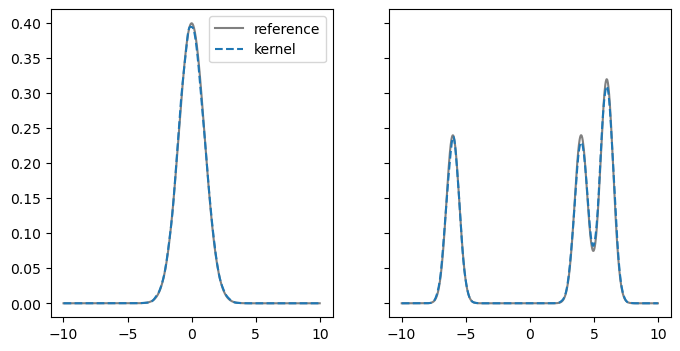

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x345927d00>

In [22]:
Random.seed!(42)
Ny, dim = 40000, 1

T = 4.0
# Initial condition
Y0 = rand(Normal(0, 1), (Ny, dim))
 
# Visualize initial condition

cbandwidth(t) = (4/(Ny*(dim + 2)))^(1/(dim+4)) * (0.5*t/T + 1.0*(1 - t/T)) 

x_l, x_r, Ne = -10, 10, 1000
Δx = (x_r - x_l) / Ne
xx = LinRange(x_l, x_r, Ne + 1)
xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
ρ0 = compute_qt([1.0;], [0.0;;], [1.0;;;], 0.0, Array(reshape(xc, (Ne, 1))))        
kernel = kde(Y0[:,1], bandwidth=cbandwidth(0.0))
ρ̂0 = pdf(kernel, xc)
ρT = compute_qt(x_w, x_mean, xx_cov, 0.0, Array(reshape(xc, (Ne, 1))))        
YT = rand(MixtureModel(Normal[
   Normal(x_mean[1,1], sqrt(xx_cov[1,1,1])),
   Normal(x_mean[2,1], sqrt(xx_cov[2,1,1])),
   Normal(x_mean[3,1], sqrt(xx_cov[3,1,1]))], x_w), (Ny, dim))
    
kernel = kde(YT[:,1], bandwidth=cbandwidth(0.0))
ρ̂T = pdf(kernel, xc)
fig, ax = fig, ax = PyPlot.subplots(nrows = 1, ncols=2, sharex=true, sharey="row", figsize=(8,4))
ax[1].plot(xc, ρ0, "-", color="grey", label="reference")
ax[1].plot(xc, ρ̂0, "--", color="C0", label="kernel")
ax[1].legend()
ax[2].plot(xc, ρT, "-", color="grey", label="reference")
ax[2].plot(xc, ρ̂T, "--", color="C0", label="kernel")


## Compute

In [23]:
error_types = ["constant"; "linear"; "sinusoidal"]
δs = [0.01; 0.02; 0.04; 0.08; 0.16]
#Nts= [40;   40;   40;   40;   40]
Nts= [32;   24;   16;   12;   8]
Ntype = length(error_types) 
Nδ = length(δs)

Nsave_ts_ind = 5
Ys = zeros(Ntype, Nδ, Nsave_ts_ind, Ny, dim) 
for itype = 1:Ntype
    for iδ = 1:Nδ 
        Nt = Nts[iδ]
        ts = LinRange(0, T, Nt+1)
        save_ts_ind = Array(0:div(Nt,Nsave_ts_ind-1):Nt)
        compute_V(t, xx) = compute_U(t, xx) + score_error(x_w, x_mean, xx_cov, δs[iδ], t, T, (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx) ;error_type = error_types[itype])
        Ys[itype, iδ, :, :, :], _ = solve(T, Nt, Y0, compute_V; ts=ts, save_ts_ind=save_ts_ind) 
    end
end

In [24]:
q0 = compute_qt(x_w, x_mean, xx_cov, 0.0, Array(reshape(xc, (Ne, 1))))
TVes = zeros(Ntype, Nδ) 
rmeanes = zeros(Ntype, Nδ)   #relative mean error
rcoves = zeros(Ntype, Nδ)    #relative covariance error
GM_mean = x_w' * x_mean[:,1]
GM_cov = x_w' * xx_cov[:,1,1] + x_w'* (x_mean[:,1] .- GM_mean).^2

for itype = 1:Ntype
    for iδ = 1:Nδ 
        YT = Ys[itype, iδ, end, :, :]
        kernel = kde(YT[:,1], bandwidth=cbandwidth(0.0))
        ρ̂T = pdf(kernel, xc)
        
        TVes[itype, iδ]   = sum(abs.(ρ̂T - q0)) / 2.0 * (xc[2] - xc[1])
        GM_mean_esti = sum(YT[:, 1])/Ny
        rmeanes[itype, iδ] = abs(GM_mean_esti - GM_mean) / GM_mean
        rcoves[itype, iδ]  = abs(sum((YT[:, 1] .- GM_mean_esti).^2)/Ny - GM_cov) / GM_cov

    end
end

## Visualize

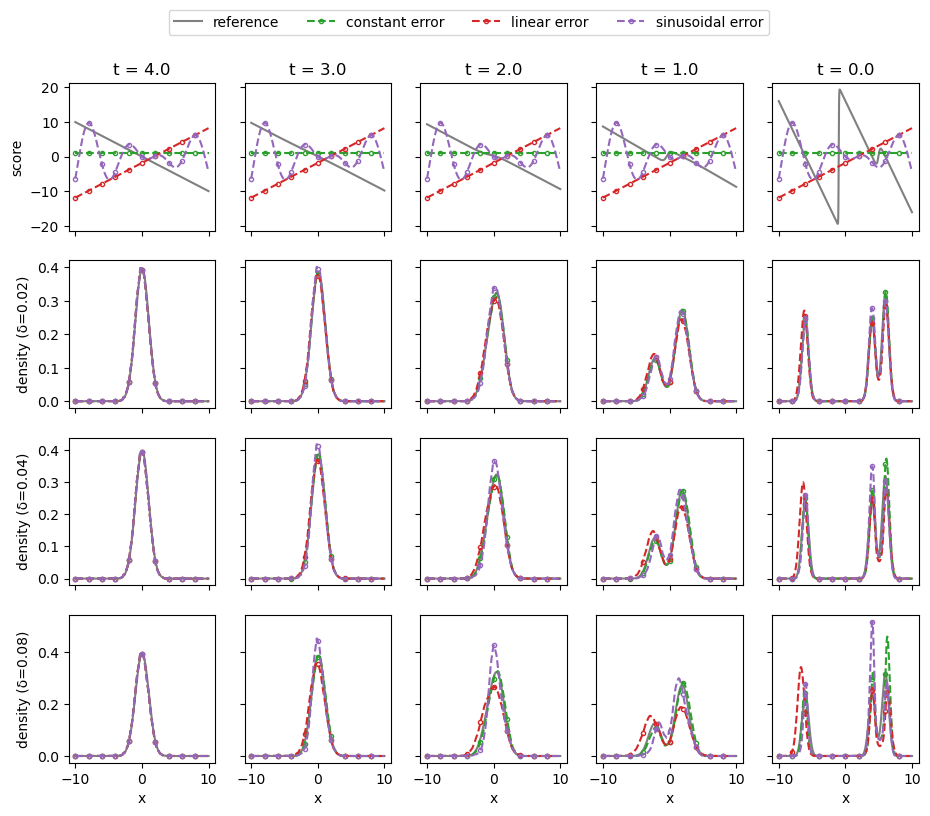

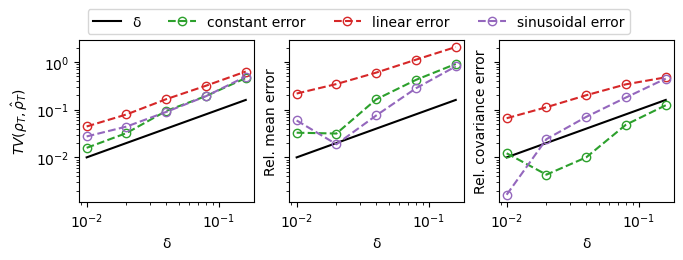

In [25]:
nrows, ncols = 4, 5
fig, ax = fig, ax = PyPlot.subplots(nrows = nrows, ncols=ncols, sharex=true, sharey="row", figsize=(10,8))

    
## plot score at different time
for i  = 1:ncols
    t = T - T*(i-1)/(ncols - 1)
    δ = 1.0
    ∇logqt = compute_qt_score(x_w, x_mean, xx_cov, t, Array(reshape(xc, (Ne, 1))))
    ax[1, i].plot(xc, ∇logqt, "-", color = "grey", fillstyle="none", label="reference")
    for itype = 1:Ntype
        err = score_error(x_w, x_mean, xx_cov, δ, t, T,  Array(reshape(xc, (Ne, 1))); error_type = error_types[itype])
        ax[1, i].plot(xc, err, "--o", color = "C"*string(itype+1), fillstyle="none", markevery=100, markersize = 3, label = error_types[itype]*" error")
    end
    
    ax[1, i].title.set_text("t = "*string(t))
    ax[nrows, i].set_xlabel("x")
end
ax[1,1].set_ylabel("score")

    
## plot qt at different time
for i  = 1:ncols
    t = T - T*(i-1)/(ncols - 1)
    qt = compute_qt(x_w, x_mean, xx_cov, t, Array(reshape(xc, (Ne, 1))))
    for j = 2:nrows
        ax[j, i].plot(xc, qt,   "-", color = "grey", fillstyle="none", label="reference")
        ax[j, 1].set_ylabel("density (δ=0.0" * string(2^(j-1))*")")
    end
end


for itype = 1:Ntype
    for iδ = 1:min(Nδ, nrows-1) 
        for i  = 1:ncols
            t = T - T*(i-1)/(ncols - 1)
#             ir =  Int(Nt*(ncols - i)/(ncols - 1)) + 1
            kernel = kde(Ys[itype, iδ+1, i, :, 1], bandwidth=cbandwidth(t))
            ρ̂t = pdf(kernel, xc)
            ax[iδ+1, i].plot(xc, ρ̂t, "--o", color = "C"*string(itype+1), fillstyle="none", markevery=100, markersize = 3)
        end
    end
end
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
fig.subplots_adjust(bottom=0.05,top=0.9,left=0.1,right=0.95,hspace=0.2)
fig.savefig("1D-ode-density.pdf")

fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=true, sharey="row", figsize=(7, 2.5))
for i = 1:3
    ax[i].loglog(δs, δs, "-", color = "black", fillstyle="none", label="δ")
    ax[i].set_xlabel("δ");
end
for itype = 1:Ntype
    ax[1].loglog(δs, TVes[itype, :], "--o", color = "C"*string(itype+1), fillstyle="none", label = error_types[itype]*" error")  
    ax[2].loglog(δs, rmeanes[itype, :], "--o", color = "C"*string(itype+1), fillstyle="none", label = error_types[itype]*" error")  
    ax[3].loglog(δs, rcoves[itype, :], "--o", color = "C"*string(itype+1), fillstyle="none", label = error_types[itype]*" error")  
end
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
ax[1].set_ylabel(L"TV(\rho_T,\hat{\rho}_T)")
ax[2].set_ylabel("Rel. mean error")
ax[3].set_ylabel("Rel. covariance error")
fig.subplots_adjust(bottom=0.2,top=0.85,left=0.1,right=0.95,hspace=0.2)
fig.savefig("1D-ode-error.pdf")



# High dimensional ODE solver
## Setup
We follow the setup in Albergo, Michael S., Nicholas M. Boffi, and Eric Vanden-Eijnden. "Stochastic interpolants: A unifying framework for flows and diffusions." arXiv preprint arXiv:2303.08797 (2023).

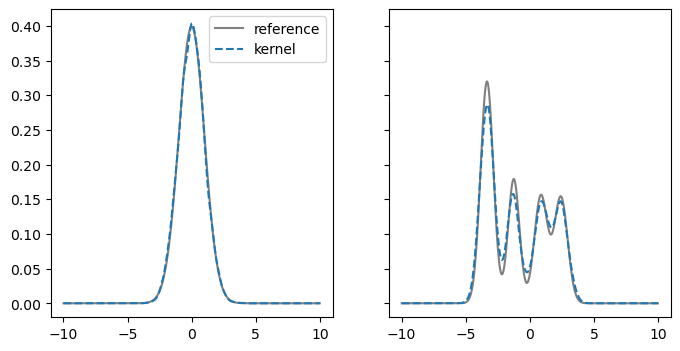

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3d8c399c0>

In [72]:
Random.seed!(123)
# Ny, dim = 40000, 128
Ny, dim = 10000, 16
N_modes = 5
x_w =  ones(N_modes)/N_modes
x_mean = 3.0*rand(Normal(0, 1), (N_modes, dim))
xx_cov = zeros(N_modes, dim, dim)

for i = 1:N_modes
    W = rand(Normal(0, 1), (dim, dim))
    xx_cov[i,:,:] = 0.25*(W'*W/dim + I)/2.0
    # xx_cov[i,:,:] += 0.25*I
end

T, Nt = 4.0, 100
Y0 = rand(Normal(0, 1), (Ny, dim))
 

cbandwidth(t) = (4/(Ny*(1 + 2)))^(1/(1+4)) * (sqrt(2)*t/T + 1.0*(1 - t/T)) 

x_l, x_r, Ne = -10, 10, 1000
Δx = (x_r - x_l) / Ne
xx = LinRange(x_l, x_r, Ne + 1)
xc = (xx[1:Ne] + xx[2:Ne+1])/2.0


# Visualize initial condition
fig, ax = fig, ax = PyPlot.subplots(nrows = 1, ncols=2, sharex=true, sharey="row", figsize=(8,4))

ρ0 = compute_qt([1.0;], [0.0;;], [1.0;;;], 0.0, Array(reshape(xc, (Ne, 1))))        
kernel = kde(Y0[:,1], bandwidth=cbandwidth(0.0))
ρ̂0 = pdf(kernel, xc)
ax[1].plot(xc, ρ0, "-", color="grey", label="reference")
ax[1].plot(xc, ρ̂0, "--", color="C0", label="kernel")
ax[1].legend()


ρT = compute_qt(x_w, x_mean[:, 1:1], xx_cov[:,1:1,1:1], 0.0, Array(reshape(xc, (Ne, 1))))        
YT = rand(MixtureModel(MvNormal[
   MvNormal(x_mean[1,:],  xx_cov[1,:,:]),
   MvNormal(x_mean[2,:],  xx_cov[2,:,:]),
   MvNormal(x_mean[3,:],  xx_cov[3,:,:]),
   MvNormal(x_mean[4,:],  xx_cov[4,:,:]),
   MvNormal(x_mean[5,:],  xx_cov[5,:,:])], x_w), (Ny))
    
kernel = kde(YT[1,:], bandwidth=cbandwidth(T))
ρ̂T = pdf(kernel, xc)
ax[2].plot(xc, ρT, "-", color="grey", label="reference")
ax[2].plot(xc, ρ̂T, "--", color="C0", label="kernel")


In [73]:
x_mean

5×16 Matrix{Float64}:
  2.42486    0.689456   3.65784    …  -4.39683    0.550919   3.44428
 -3.36622   -1.26531    0.878743       2.08871   -2.90211   -0.834811
 -3.31391   -4.06677   -0.0934444     -0.674884   0.894689   1.01067
 -1.25098    0.208377   0.947499       0.268037  -0.494792   0.588222
  0.862764  -0.351968  -6.48714        2.76374   -4.2388     1.87323

## Compute

In [ ]:
error_types = ["constant"; "linear"; "sinusoidal"]
# δs = [0.01; 0.02; 0.04; 0.08; 0.16]
# Nts= [32;   24;   16;   12;   8]
δs = [0.0; 0.0; 0.0]
Nts= [64;   32;  16]
Ntype = length(error_types) 
Nδ = length(δs)

Nsave_ts_ind = 5
Ys = zeros(Ntype, Nδ, Nsave_ts_ind, Ny, dim) 
for itype = 1:Ntype
    for iδ = 1:Nδ 
        @info error_types[itype], δs[iδ]
        Nt = Nts[iδ]
        ts = LinRange(0, T, Nt+1)
        save_ts_ind = Array(0:div(Nt,Nsave_ts_ind-1):Nt)
        compute_V(t, xx) = compute_U(t, xx) + score_error(x_w, x_mean, xx_cov, δs[iδ], t, T, (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx) ;error_type = error_types[itype])
        Ys[itype, iδ, :, :, :], _ = solve(T, Nt, Y0, compute_V; ts=ts, save_ts_ind=save_ts_ind) 
    end
end

npzwrite("Ys.npy", Ys)

In [ ]:
# marginal distribution
q0 = compute_qt(x_w, x_mean[:,1:1], xx_cov[:,1:1,1:1], 0.0, Array(reshape(xc, (Ne, 1))))
TVes = zeros(Ntype, Nδ) 
rmeanes = zeros(Ntype, Nδ)   #relative mean error
rcoves = zeros(Ntype, Nδ)    #relative covariance error
GM_mean = x_mean' * x_w 
GM_cov = zeros(dim, dim)
for i = 1:N_modes
    GM_cov += x_w[i] * (xx_cov[i,:,:] + (x_mean[i,:] - GM_mean)*(x_mean[i,:] - GM_mean)')
end

for itype = 1:Ntype
    for iδ = 1:Nδ 
        YT = Ys[itype, iδ, end, :, :]
        kernel = kde(YT[:,1], bandwidth=cbandwidth(0.0)) #project to the first component
        ρ̂T = pdf(kernel, xc)
        TVes[itype, iδ]   = sum(abs.(ρ̂T - q0)) / 2.0 * (xc[2] - xc[1])
        GM_mean_esti = sum(YT, dims=1)[:]/Ny
        rmeanes[itype, iδ] = norm(GM_mean_esti - GM_mean) / norm(GM_mean)
        rcoves[itype, iδ]  = norm((YT - ones(Ny)*GM_mean_esti')'*(YT - ones(Ny)*GM_mean_esti')/Ny - GM_cov) / norm(GM_cov)
        
        @info error_types[itype], δs[iδ],  "mean: ", norm(GM_mean_esti - GM_mean), norm(GM_mean)
        @info error_types[itype], δs[iδ],  "TV: ", TVes[itype, iδ], " cov: ", rcoves[itype, iδ] 
    end
end

In [59]:
nrows, ncols = 4, 5
fig, ax = fig, ax = PyPlot.subplots(nrows = nrows, ncols=ncols, sharex=true, sharey="row", figsize=(10,8))

    
## plot marginal score at different time
for i  = 1:ncols
    t = T - T*(i-1)/(ncols - 1)
    δ = 1.0
    ∇logqt = compute_qt_score(x_w, x_mean[:,1:1], xx_cov[:,1:1,1:1], t, Array(reshape(xc, (Ne, 1))))
    ax[1, i].plot(xc, ∇logqt, "-", color = "grey", fillstyle="none", label="reference")
    for itype = 1:Ntype
        # err = score_error(x_w, x_mean, xx_cov, δ, t, T,  Array(reshape(xc, (Ne, 1))); error_type = error_types[itype])
        # ax[1, i].plot(xc, err, "--o", color = "C"*string(itype+1), fillstyle="none", markevery=100, markersize = 3, label = error_types[itype]*" error")
    end
    
    ax[1, i].title.set_text("t = "*string(t))
end
ax[1,1].set_ylabel("score")

    
## plot marginal qt at different time
for i  = 1:ncols
    t = T - T*(i-1)/(ncols - 1)
    qt = compute_qt(x_w, x_mean[:,1:1], xx_cov[:,1:1,1:1], t, Array(reshape(xc, (Ne, 1))))
    for j = 2:nrows
        ax[j, i].plot(xc, qt,   "-", color = "grey", fillstyle="none", label="reference")
        ax[j, 1].set_ylabel("density (δ=0.0" * string(2^(j-1))*")")
    end
end

# marginal 
for itype = 1:Ntype
    for iδ = 1:min(Nδ, nrows-1) 
        for i  = 1:ncols
            t = T - T*(i-1)/(ncols - 1)
            kernel = kde(Ys[itype, iδ+1, i, :, 1], bandwidth=cbandwidth(t))
            ρ̂t = pdf(kernel, xc)
            ax[iδ+1, i].plot(xc, ρ̂t, "--o", color = "C"*string(itype+1), fillstyle="none", markevery=100, markersize = 3)
        end
    end
end
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
fig.subplots_adjust(bottom=0.1,top=0.90,left=0.1,right=0.95,hspace=0.2)
fig.savefig("high-D-ode-density.pdf")

fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=true, sharey="row", figsize=(7, 2.5))
for i = 1:3
    ax[i].loglog(δs, δs, "-", color = "black", fillstyle="none", label="δ")
    ax[i].set_xlabel("δ");
end
for itype = 1:Ntype
    ax[1].loglog(δs, TVes[itype, :], "--o", color = "C"*string(itype+1), fillstyle="none", label = error_types[itype]*" error")  
    ax[2].loglog(δs, rmeanes[itype, :], "--o", color = "C"*string(itype+1), fillstyle="none", label = error_types[itype]*" error")  
    ax[3].loglog(δs, rcoves[itype, :], "--o", color = "C"*string(itype+1), fillstyle="none", label = error_types[itype]*" error")  
end
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
ax[1].set_ylabel(L"TV(\rho_T,\hat{\rho}_T)")
ax[2].set_ylabel("Rel. mean error")
ax[3].set_ylabel("Rel. covariance error")
fig.subplots_adjust(bottom=0.1,top=0.85,left=0.1,right=0.95,hspace=0.2)
fig.savefig("high-D-ode-error.pdf")



LoadError: BoundsError: attempt to access 3×2×5×10000×16 Array{Float64, 5} at index [1, 3, 1, 1:10000, 1]